<a href="https://colab.research.google.com/github/DSGP-Group-1-EAPS/SL-Apparel-Dataset/blob/Kavindu-Deshanjana/TimeSeries_Test_K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


# Mounting the Google Drive
drive.mount('/content/drive')

# Reading the data from the excel file and removing blank spaces in each cell
df = pd.read_excel('/content/drive/MyDrive/DSGP_COURSEWORK/SL Apparel Dataset model/Dataset/SL Apparel Industry Dataset.xlsx').apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Reading the JoinDates.xlsx file
join_dates_df = pd.read_excel('/content/drive/MyDrive/DSGP_COURSEWORK/SL Apparel Dataset model/Dataset/JoinedDates.xlsx')

# Merging the SL Apparel Industry Dataset with the Join Dates based on the 'Code' column
df = pd.merge(df, join_dates_df, on='Code', how='left')

df['Date'] = pd.to_datetime(df['Date'])

df['Joined Date'] = pd.to_datetime(df['Joined Date'])
# Calculating the number of years each employee has worked
df['DaysWorked'] = (df['Date'] - df['Joined Date']).dt.days

# Making the 'Absenteeism Type' considered as String
df['Absenteeism Type'] = df['Absenteeism Type'].astype(str)

# Add a column for the day of the week (1-7)
df['DayOfWeek'] = df['Date'].dt.dayofweek + 1

# Add a column for the month (1-12)
df['Month'] = df['Date'].dt.month

# Removing rows with 'Resignation', 'VOP', 'Funeral' from the 'Reason' column
reasons_to_remove = ['Resignation', 'VOP', 'Funeral']
df = df[~df['Reason'].isin(reasons_to_remove)]

# Removing rows where 'Leave Type' is 0.5
df = df[df['Leave Type'] != 0.5]

# Removing all the rows except for 'Shift A' and 'Shift B' in the 'Shift' column
df = df[df['Shift'] != 'A']
df = df[df['Shift'] != 'Shift']
df = df[df['Shift'] != 'Other Teams']
df = df[df['Shift'] != 'Shift e']

# Removing 'Department' and 'Reason Mapping' columns
df = df.drop(['Reason Mapping'], axis=1)

# Removing rows where 'Absenteeism Type' is 1
df = df[df['Absenteeism Type'] != '1']

# Using LabelEncoder to encode the values in columns
label_encoder = LabelEncoder()
df['Encoded Reason'] = label_encoder.fit_transform(df['Reason'])
df['Encoded Status'] = label_encoder.fit_transform(df['Status'])
df['Encoded Absenteeism Type'] = label_encoder.fit_transform(df['Absenteeism Type'])
df['Encoded Shift'] = label_encoder.fit_transform(df['Shift'])
df['TookLeaveNextMonth'] = (df['Absent/Present'].eq('Absent') & (df['Date'].dt.month != (df['Date'] + pd.DateOffset(months=1)).dt.month)).astype(int)

# Removing the rows if it has a blank cell in it
df = df.dropna()

# Creating a mapping dictionary with the original values for clear understanding
reason_mapping = {
    'Reason': dict(zip(df['Encoded Reason'], df['Reason'])),
    'Status': dict(zip(df['Encoded Status'], df['Status'])),
    'Absenteeism_Type': dict(zip(df['Encoded Absenteeism Type'], df['Absenteeism Type'])),
    'Shift': dict(zip(df['Encoded Shift'], df['Shift']))
}

# Save the mapping dictionary to a text file
with open('/content/drive/MyDrive/DSGP_COURSEWORK/SL Apparel Dataset model/Dataset/reason_mapping.txt', 'w') as f:
    for category, mappings in reason_mapping.items():
        f.write(f"{category}:\n")
        for encoded_value, original_value in mappings.items():
            f.write(f"  {encoded_value}: {original_value}\n")

# Save the new preprocessed data to a new excel file in Google Drive
df.to_excel('/content/drive/MyDrive/DSGP_COURSEWORK/SL Apparel Dataset model/Dataset/preprocessed_data.xlsx', index=False)
print("Done")




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Done


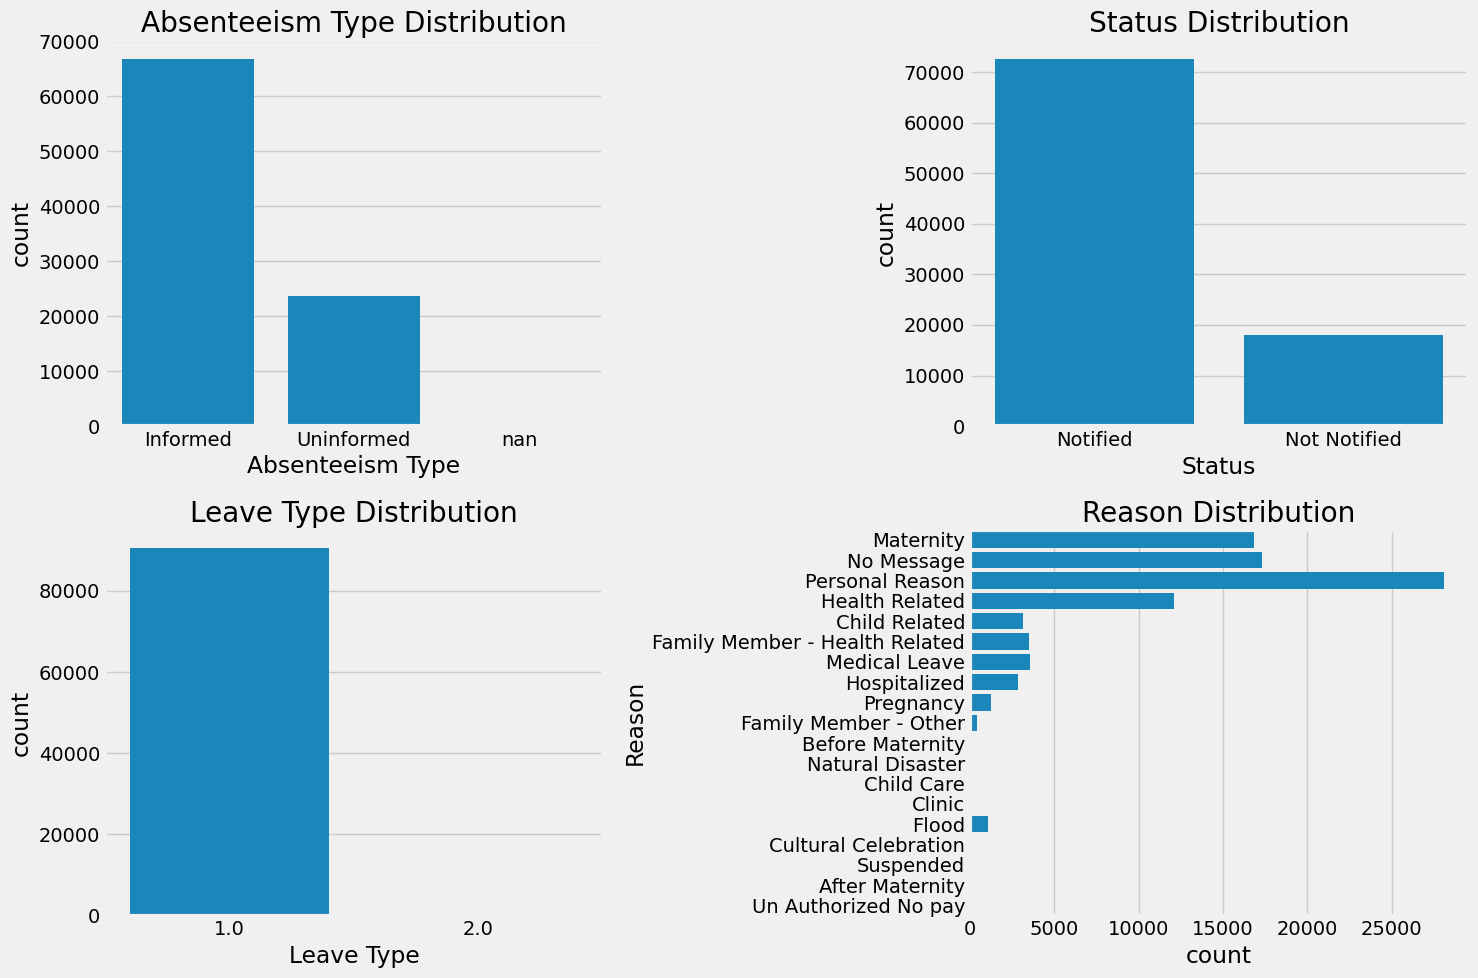

<ipython-input-6-adfa7e2212d2>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='DaysWorked', ax=axes[0, 1], palette='Blues')
<ipython-input-6-adfa7e2212d2>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='dayofweek', y='DaysWorked', ax=axes[1, 0], palette='Greens')
<ipython-input-6-adfa7e2212d2>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='quarter', y='DaysWorked', ax=axes[1, 1], palette='Reds')


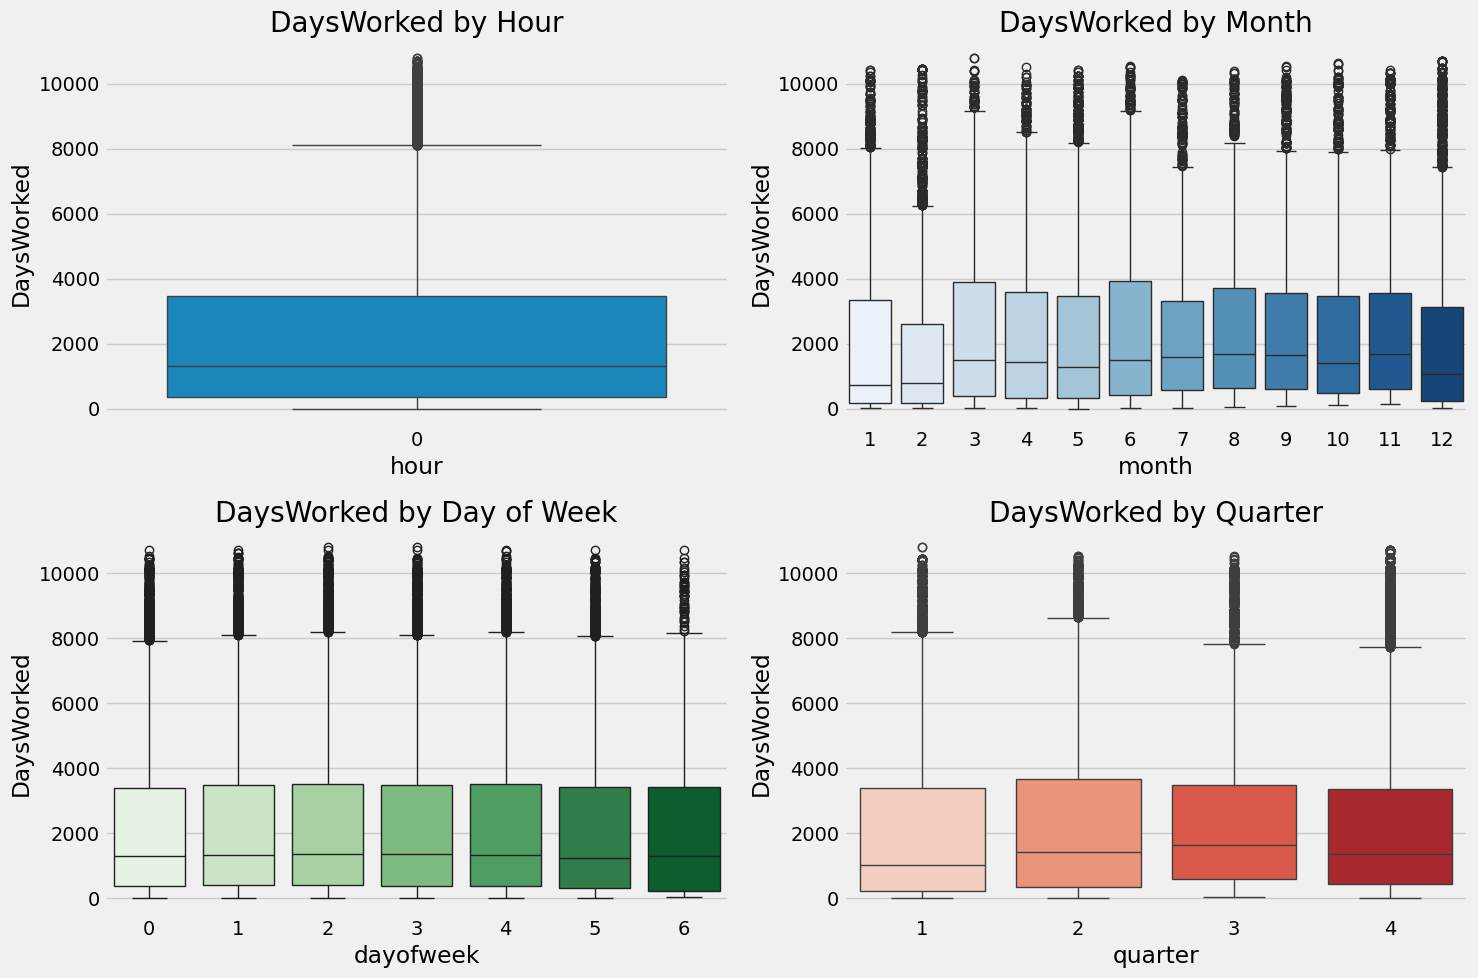

In [ ]:

# Visualize data
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Plot Absenteeism Type distribution
sns.countplot(data=df, x='Absenteeism Type', ax=axes[0, 0])
axes[0, 0].set_title('Absenteeism Type Distribution')

# Plot Status distribution
sns.countplot(data=df, x='Status', ax=axes[0, 1])
axes[0, 1].set_title('Status Distribution')

# Plot Leave Type distribution
sns.countplot(data=df, x='Leave Type', ax=axes[1, 0])
axes[1, 0].set_title('Leave Type Distribution')

# Plot Reason distribution
sns.countplot(data=df, y='Reason', ax=axes[1, 1])
axes[1, 1].set_title('Reason Distribution')
plt.tight_layout()
plt.show()

# Create time series features
def create_time_series_features(df):
    """
    Create time series features based on 'Date' column.
    """
    df['hour'] = df['Date'].dt.hour
    # df['Date'] = df['Date'].dt.Date
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.isocalendar().week
    return df
    # df['hour'] = df['Joined Date'].dt.hour
    # df['dayofweek'] = df['Joined Date'].dt.dayofweek
    # df['quarter'] = df['Joined Date'].dt.quarter
    # df['month'] = df['Joined Date'].dt.month
    # df['year'] = df['Joined Date'].dt.year
    # df['dayofyear'] = df['Joined Date'].dt.dayofyear
    # df['dayofmonth'] = df['Joined Date'].dt.day
    # df['weekofyear'] = df['Joined Date'].dt.isocalendar().week
    # return df

# Apply function to create time series features
df = create_time_series_features(df)

# Visualize time series features
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
# Plot DaysWorked by Hour
sns.boxplot(data=df, x='hour', y='DaysWorked', ax=axes[0, 0])
axes[0, 0].set_title('DaysWorked by Hour')

# Plot DaysWorked by Month
sns.boxplot(data=df, x='month', y='DaysWorked', ax=axes[0, 1], palette='Blues')
axes[0, 1].set_title('DaysWorked by Month')

# Plot DaysWorked by Day of Week
sns.boxplot(data=df, x='dayofweek', y='DaysWorked', ax=axes[1, 0], palette='Greens')
axes[1, 0].set_title('DaysWorked by Day of Week')

# Plot DaysWorked by Quarter
sns.boxplot(data=df, x='quarter', y='DaysWorked', ax=axes[1, 1], palette='Reds')
axes[1, 1].set_title('DaysWorked by Quarter')

plt.tight_layout()
plt.show()


In [ ]:
train = df[df['Date'] <= '2022-12-31']
test = df[df['Date'] > '2022-12-31']

train = create_time_series_features(train)
test = create_time_series_features(test)

features =['Encoded Reason', 'Encoded Status', 'Encoded Absenteeism Type', 'Encoded Shift', 'DaysWorked', 'DayOfWeek', 'Month']
target = 'TookLeaveNextMonth'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]





<ipython-input-6-adfa7e2212d2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['Date'].dt.hour
<ipython-input-6-adfa7e2212d2>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df['Date'].dt.dayofweek
<ipython-input-6-adfa7e2212d2>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:0.49605	validation_1-rmse:0.49659


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:02:31] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:0.27856	validation_1-rmse:0.32253
[200]	validation_0-rmse:0.23254	validation_1-rmse:0.29563
[300]	validation_0-rmse:0.22366	validation_1-rmse:0.29039
[400]	validation_0-rmse:0.22081	validation_1-rmse:0.28829
[495]	validation_0-rmse:0.21932	validation_1-rmse:0.28838


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

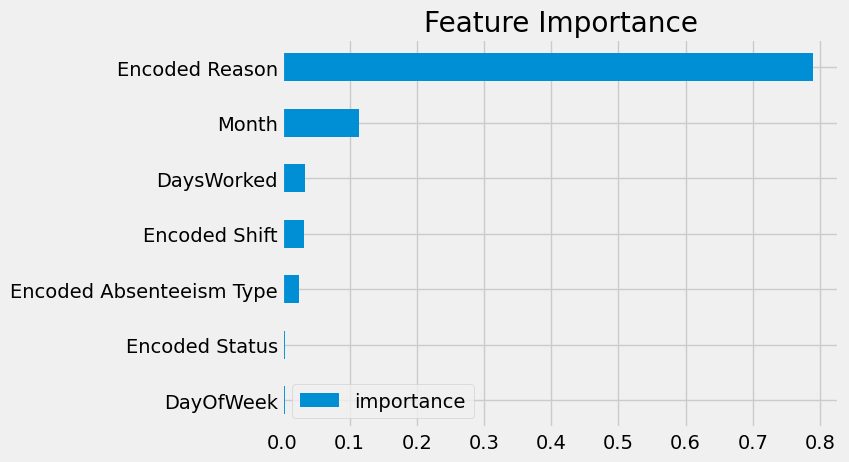

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

<ipython-input-10-081c59fa7206>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


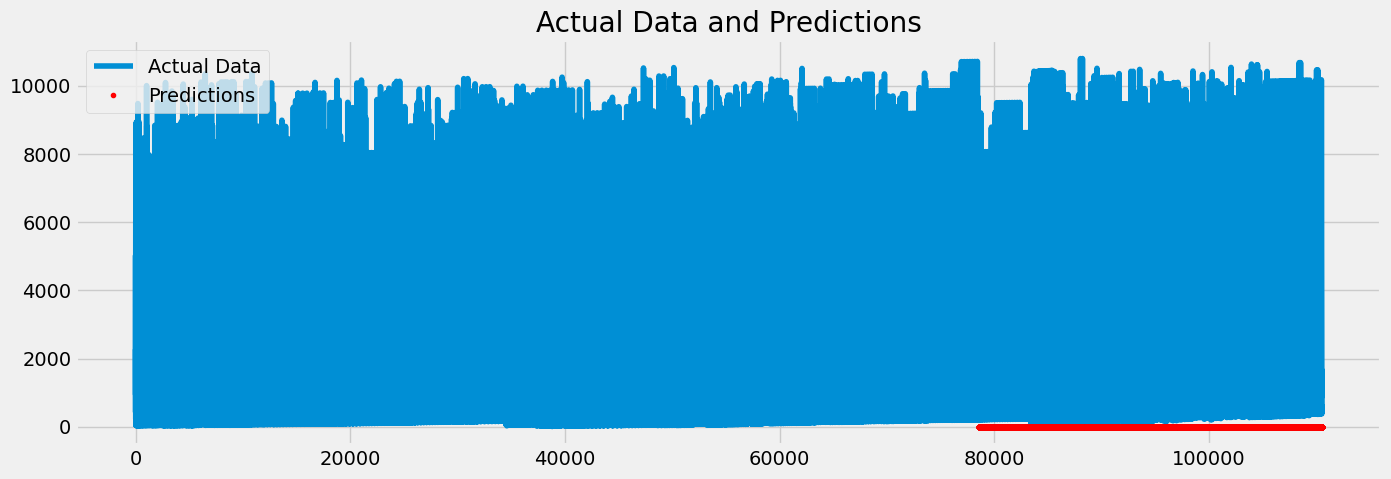

In [ ]:
# test['prediction'] = reg.predict(X_test)
# df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
# ax = df[['PJME_MW']].plot(figsize=(15, 5))
# df['prediction'].plot(ax=ax, style='.')
# plt.legend(['Truth Data', 'Predictions'])
# ax.set_title('Raw Dat and Prediction')
# plt.show()

test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['DaysWorked']].plot(figsize=(15, 5))  # Assuming 'DaysWorked' is the actual data column
df['prediction'].plot(ax=ax, style='.', color='red')  # Plotting predictions
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Actual Data and Predictions')  # Correcting the title
plt.show()



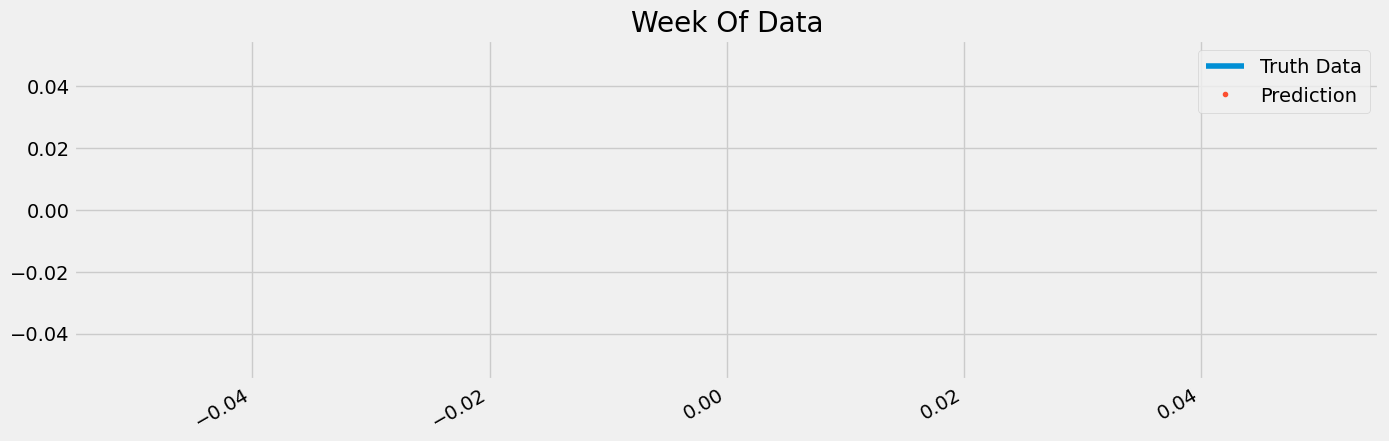

In [ ]:
# Convert index to datetime if it's not already in datetime format
df.index = pd.to_datetime(df.index)

# Plotting
ax = df.loc[(df.index > '2021-04-01') & (df.index < '2022-04-08'), 'DaysWorked'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '2022-04-01') & (df.index < '2022-04-08'), 'prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()


In [ ]:
score = np.sqrt(mean_squared_error(test['DaysWorked'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3488.09


In [ ]:
test['error'] = np.abs(test[target] - test['prediction'])
test['DaysWorked'] = test.index.date
test.groupby(['DaysWorked'])['error'].mean().sort_values(ascending=False).head(10)

AttributeError: 'Int64Index' object has no attribute 'date'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-25-f8f3f0b93232>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['Date'].dt.hour
<ipython-input-25-f8f3f0b93232>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df['Date'].dt.dayofweek
<ipython-input-25-f8f3f0b93232>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

[0]	validation_0-logloss:0.68528	validation_1-logloss:0.68635
[100]	validation_0-logloss:0.30695	validation_1-logloss:0.36608
[200]	validation_0-logloss:0.20997	validation_1-logloss:0.29377
[300]	validation_0-logloss:0.18064	validation_1-logloss:0.27386
[400]	validation_0-logloss:0.16996	validation_1-logloss:0.26818
[500]	validation_0-logloss:0.16416	validation_1-logloss:0.26628
[600]	validation_0-logloss:0.16022	validation_1-logloss:0.26643
[606]	validation_0-logloss:0.16005	validation_1-logloss:0.26655


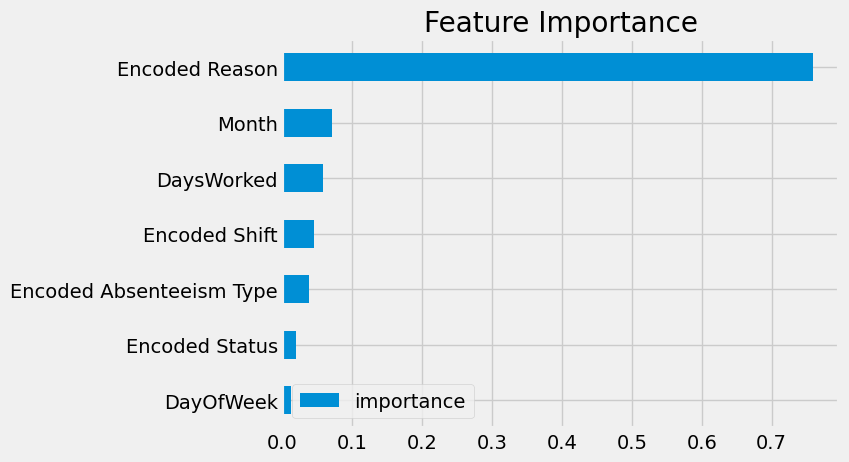

Accuracy: 86.44%
Employees' IDs predicted to be absent next month:
78582     AA3785
78583     AA2316
78586     AA1465
78587     AA3790
78594     AA2943
           ...  
110526    AA4072
110528    AA3609
110529    AA3658
110531    AA3992
110532    AA3659
Name: Code, Length: 22271, dtype: object
RMSE Score on Test set: 0.37


<ipython-input-25-f8f3f0b93232>:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Mounting the Google Drive
drive.mount('/content/drive')

# Reading the data from the excel file and removing blank spaces in each cell
df = pd.read_excel('/content/drive/MyDrive/DSGP_COURSEWORK/SL Apparel Dataset model/Dataset/SL Apparel Industry Dataset.xlsx').apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Reading the JoinDates.xlsx file
join_dates_df = pd.read_excel('/content/drive/MyDrive/DSGP_COURSEWORK/SL Apparel Dataset model/Dataset/JoinedDates.xlsx')

# Merging the SL Apparel Industry Dataset with the Join Dates based on the 'Code' column
df = pd.merge(df, join_dates_df, on='Code', how='left')

df['Date'] = pd.to_datetime(df['Date'])
df['Joined Date'] = pd.to_datetime(df['Joined Date'])

# Calculating the number of days each employee has worked
df['DaysWorked'] = (df['Date'] - df['Joined Date']).dt.days

# Making the 'Absenteeism Type' considered as String
df['Absenteeism Type'] = df['Absenteeism Type'].astype(str)

# Add a column for the day of the week (1-7)
df['DayOfWeek'] = df['Date'].dt.dayofweek + 1

# Add a column for the month (1-12)
df['Month'] = df['Date'].dt.month

# Removing rows with 'Resignation', 'VOP', 'Funeral' from the 'Reason' column
reasons_to_remove = ['Resignation', 'VOP', 'Funeral']
df = df[~df['Reason'].isin(reasons_to_remove)]

# Removing rows where 'Leave Type' is 0.5
df = df[df['Leave Type'] != 0.5]

# Removing all the rows except for 'Shift A' and 'Shift B' in the 'Shift' column
shifts_to_keep = ['Shift A', 'Shift B']
df = df[df['Shift'].isin(shifts_to_keep)]

# Removing 'Department' and 'Reason Mapping' columns
df = df.drop(['Department', 'Reason Mapping'], axis=1)

# Removing rows where 'Absenteeism Type' is 1
df = df[df['Absenteeism Type'] != '1']

# Using LabelEncoder to encode the values in columns
label_encoder = LabelEncoder()
df['Encoded Reason'] = label_encoder.fit_transform(df['Reason'])
df['Encoded Status'] = label_encoder.fit_transform(df['Status'])
df['Encoded Absenteeism Type'] = label_encoder.fit_transform(df['Absenteeism Type'])
df['Encoded Shift'] = label_encoder.fit_transform(df['Shift'])

# Create target variable: AbsentNextMonth
df['TookLeaveNextMonth'] = (df['Absent/Present'].eq('Absent') & (df['Date'].dt.month != (df['Date'] + pd.DateOffset(months=1)).dt.month)).astype(int)

# Drop rows with missing values
df = df.dropna()

# Define features and target variable
features = ['Encoded Reason', 'Encoded Status', 'Encoded Absenteeism Type', 'Encoded Shift', 'DaysWorked', 'DayOfWeek', 'Month']
target = 'TookLeaveNextMonth'

# Split data into training and testing sets
train = df[df['Date'] <= '2022-12-31']
test = df[df['Date'] > '2022-12-31']

# Create time series features
def create_time_series_features(df):
    """
    Create time series features based on 'Date' column.
    """
    df['hour'] = df['Date'].dt.hour
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.isocalendar().week
    return df

# Apply function to create time series features
train = create_time_series_features(train)
test = create_time_series_features(test)

# Define features and target variables for training and testing
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

# Train the XGBoost model
reg = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
                         n_estimators=1000,
                         early_stopping_rounds=50,
                         objective='binary:logistic',
                         max_depth=3,
                         learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

# Plot feature importance
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=features,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Make predictions on the test set
test['prediction'] = reg.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(test['TookLeaveNextMonth'], test['prediction'])
print(f'Accuracy: {accuracy * 100:.2f}%')

# Emoplyees predicted to be absent
predicted_absentees_ids = test.loc[test['prediction'] == 1, 'Code']
print("Employees' IDs predicted to be absent next month:")
print(predicted_absentees_ids)




[0]	validation_0-logloss:0.68528	validation_1-logloss:0.68635
[100]	validation_0-logloss:0.30695	validation_1-logloss:0.36608
[200]	validation_0-logloss:0.20997	validation_1-logloss:0.29377
[300]	validation_0-logloss:0.18064	validation_1-logloss:0.27386
[400]	validation_0-logloss:0.16996	validation_1-logloss:0.26818
[500]	validation_0-logloss:0.16416	validation_1-logloss:0.26628
[600]	validation_0-logloss:0.16022	validation_1-logloss:0.26643
[606]	validation_0-logloss:0.16005	validation_1-logloss:0.26655


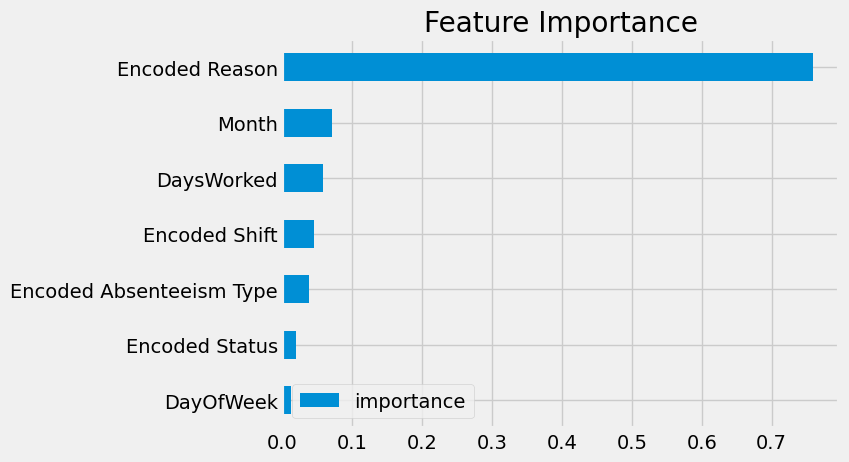

<ipython-input-24-5baf6d5d8457>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


Accuracy: 86.44%
Employees' IDs predicted to be absent next month:
78582     AA3785
78583     AA2316
78586     AA1465
78587     AA3790
78594     AA2943
           ...  
110526    AA4072
110528    AA3609
110529    AA3658
110531    AA3992
110532    AA3659
Name: Code, Length: 22271, dtype: object


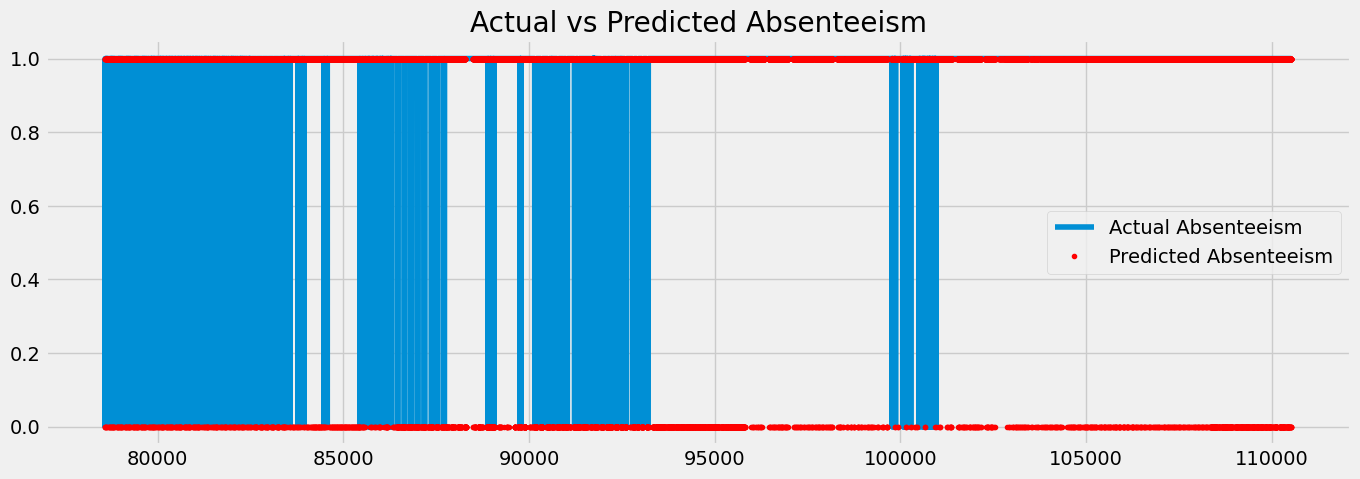

RMSE Score on Test set: 0.37


In [ ]:
# Importing accuracy_score from sklearn.metrics
from sklearn.metrics import accuracy_score

# Train the XGBoost model
reg = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
                         n_estimators=1000,
                         early_stopping_rounds=50,
                         objective='binary:logistic',
                         max_depth=3,
                         learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

# Plot feature importance
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=features,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Make predictions on the test set
test['prediction'] = reg.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(test['TookLeaveNextMonth'], test['prediction'])
print(f'Accuracy: {accuracy * 100:.2f}%')

predicted_absentees_ids = test.loc[test['prediction'] == 1, 'Code']
print("Employees' IDs predicted to be absent next month:")
print(predicted_absentees_ids)

# Plot actual vs predicted absenteeism
ax = test[['TookLeaveNextMonth']].plot(figsize=(15, 5))  # Actual absenteeism
test['prediction'].plot(ax=ax, style='.', color='red')  # Predicted absenteeism
plt.legend(['Actual Absenteeism', 'Predicted Absenteeism'])
ax.set_title('Actual vs Predicted Absenteeism')
plt.show()

# Calculate RMSE score
score = np.sqrt(mean_squared_error(test['TookLeaveNextMonth'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Mounting the Google Drive
drive.mount('/content/drive')

# Reading the data from the excel file and removing blank spaces in each cell
df = pd.read_excel('/content/drive/MyDrive/DSGP_COURSEWORK/SL Apparel Dataset model/Dataset/SL Apparel Industry Dataset.xlsx').apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Reading the JoinDates.xlsx file
join_dates_df = pd.read_excel('/content/drive/MyDrive/DSGP_COURSEWORK/SL Apparel Dataset model/Dataset/JoinedDates.xlsx')

# Merging the SL Apparel Industry Dataset with the Join Dates based on the 'Code' column
df = pd.merge(df, join_dates_df, on='Code', how='left')

df['Date'] = pd.to_datetime(df['Date'])
df['Joined Date'] = pd.to_datetime(df['Joined Date'])

# Calculating the number of days each employee has worked
df['DaysWorked'] = (df['Date'] - df['Joined Date']).dt.days

# Making the 'Absenteeism Type' considered as String
df['Absenteeism Type'] = df['Absenteeism Type'].astype(str)

# Add a column for the day of the week (1-7)
df['DayOfWeek'] = df['Date'].dt.dayofweek + 1

# Add a column for the month (1-12)
df['Month'] = df['Date'].dt.month

# Removing rows with 'Resignation', 'VOP', 'Funeral' from the 'Reason' column
reasons_to_remove = ['Resignation', 'VOP', 'Funeral']
df = df[~df['Reason'].isin(reasons_to_remove)]

# Removing rows where 'Leave Type' is 0.5
df = df[df['Leave Type'] != 0.5]

# Removing all the rows except for 'Shift A' and 'Shift B' in the 'Shift' column
shifts_to_keep = ['Shift A', 'Shift B']
df = df[df['Shift'].isin(shifts_to_keep)]

# Removing 'Department' and 'Reason Mapping' columns
df = df.drop(['Department', 'Reason Mapping'], axis=1)

# Removing rows where 'Absenteeism Type' is 1
df = df[df['Absenteeism Type'] != '1']

# Using LabelEncoder to encode the values in columns
label_encoder = LabelEncoder()
df['Encoded Reason'] = label_encoder.fit_transform(df['Reason'])
df['Encoded Status'] = label_encoder.fit_transform(df['Status'])
df['Encoded Absenteeism Type'] = label_encoder.fit_transform(df['Absenteeism Type'])
df['Encoded Shift'] = label_encoder.fit_transform(df['Shift'])

# Create target variable: Number of absent days in the next month
def calculate_absent_days(row):
    if row['Absent/Present'] == 'Absent':
        next_month = row['Date'].replace(day=1) + pd.DateOffset(months=1)
        next_month_absences = df[(df['Code'] == row['Code']) & (df['Date'].dt.month == next_month.month) & (df['Date'].dt.year == next_month.year)]
        return next_month_absences.shape[0]
    else:
        return 0

df['AbsentDaysNextMonth'] = df.apply(calculate_absent_days, axis=1)

# Drop rows with missing values
df = df.dropna()

# Define features and target variable
features = ['Encoded Reason', 'Encoded Status', 'Encoded Absenteeism Type', 'Encoded Shift', 'DaysWorked', 'DayOfWeek', 'Month']
target = 'AbsentDaysNextMonth'

# Split data into training and testing sets
train = df[df['Date'] <= '2022-12-31']
test = df[df['Date'] > '2022-12-31']

# Create time series features
def create_time_series_features(df):
    """
    Create time series features based on 'Date' column.
    """
    df['hour'] = df['Date'].dt.hour
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.isocalendar().week
    return df

# Apply function to create time series features
train = create_time_series_features(train)
test = create_time_series_features(test)

# Define features and target variables for training and testing
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

# Train the XGBoost regression model
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                        n_estimators=1000,
                        early_stopping_rounds=50,
                        max_depth=3,
                        learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='rmse',
        verbose=100)

# Plot feature importance
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=features,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Make predictions on the test set
predictions = reg.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error: {rmse:.2f}')

# Employees predicted to be absent next month with predicted number of days
predicted_absentees = pd.DataFrame({'Code': test['Code'], 'PredictedAbsentDays': predictions})
print("Employees' IDs predicted to be absent next month with predicted number of days:")
print(predicted_absentees)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyboardInterrupt: 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[0]	validation_0-rmse:9.59541	validation_1-rmse:5.89505


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:7.47093	validation_1-rmse:5.37328
[113]	validation_0-rmse:7.36684	validation_1-rmse:5.40688


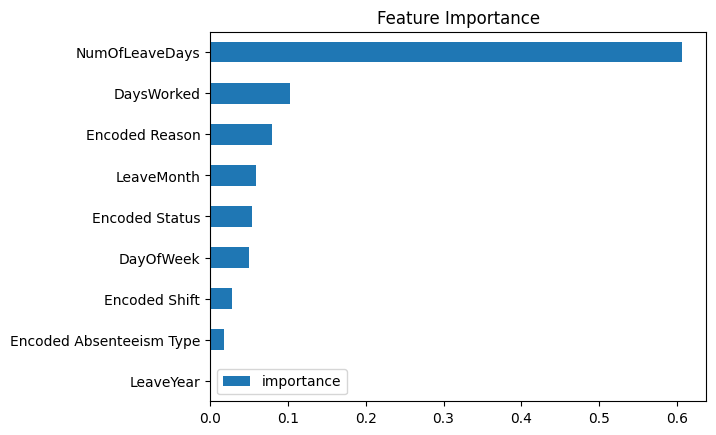

Root Mean Squared Error: 5.30
Employees' IDs predicted to be absent next month with predicted number of days (rounded up):
         Code  PredictedAbsentDays
27747  AA3785                  7.0
27748  AA2316                  7.0
27749  AA2585                  7.0
27750   AA594                  7.0
27751  AA1465                  7.0
...       ...                  ...
40661  AA2212                  2.0
40662   AA723                  2.0
40663  AA1280                  2.0
40664  AA1964                  2.0
40665    AA12                  2.0

[12919 rows x 2 columns]
Mean Absolute Error: 3.35
R-squared (R2): 0.08
Mean Squared Logarithmic Error (MSLE): 1.18062
Explained Variance Score: 0.08
Accuracy: 4.67%


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from google.colab import drive

# Mounting the Google Drive
drive.mount('/content/drive')

# Reading the preprocessed data from the specified location
df = pd.read_excel('/content/drive/MyDrive/DSGP_COURSEWORK/SL Apparel Dataset model/Dataset/preprocessed_data_new.xlsx')

# Define features and target variable
features = ['Encoded Reason', 'Encoded Status', 'Encoded Absenteeism Type', 'Encoded Shift', 'DaysWorked', 'DayOfWeek', 'LeaveMonth', 'LeaveYear', 'NumOfLeaveDays']
target = 'LeavesNextMonth'

# Split data into training and testing sets
train = df[df['Date'] <= '2022-12-31']
test = df[df['Date'] > '2022-12-31']

# Define features and target variables for training and testing
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

# Train the XGBoost regression model
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                        n_estimators=1000,
                        early_stopping_rounds=50,
                        max_depth=3,
                        learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='rmse',
        verbose=100)

# Plot feature importance
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=features,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Make predictions on the test set
predictions = reg.predict(X_test)

# Round up predicted days to nearest whole number
predictions_rounded = np.ceil(predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error: {rmse:.2f}')

# Employees predicted to be absent next month with predicted number of days
predicted_absentees = pd.DataFrame({'Code': test['Code'], 'PredictedAbsentDays': predictions_rounded})
print("Employees' IDs predicted to be absent next month with predicted number of days (rounded up):")
print(predicted_absentees)



from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error, explained_variance_score

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error: {mae:.2f}')

# Calculate R-squared (R2)
r2 = r2_score(y_test, predictions)
print(f'R-squared (R2): {r2:.2f}')

# Calculate Mean Squared Logarithmic Error (MSLE)
msle = mean_squared_log_error(y_test, predictions)
print(f'Mean Squared Logarithmic Error (MSLE): {msle:.5f}')

# Calculate Explained Variance Score
explained_variance = explained_variance_score(y_test, predictions)
print(f'Explained Variance Score: {explained_variance:.2f}')


# Importing accuracy_score from sklearn.metrics
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(test['LeavesNextMonth'], predictions_rounded)
print(f'Accuracy: {accuracy * 100:.2f}%')


